## Homework 2: Canny edge detector

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

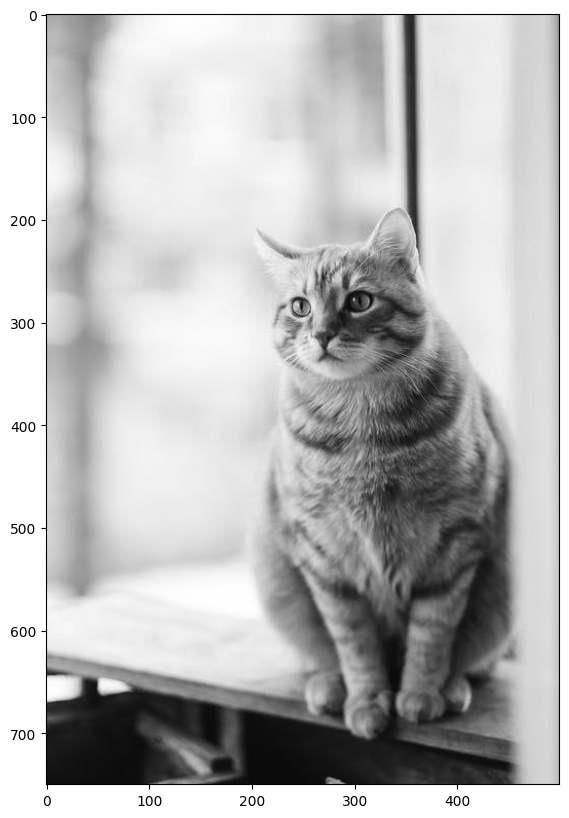

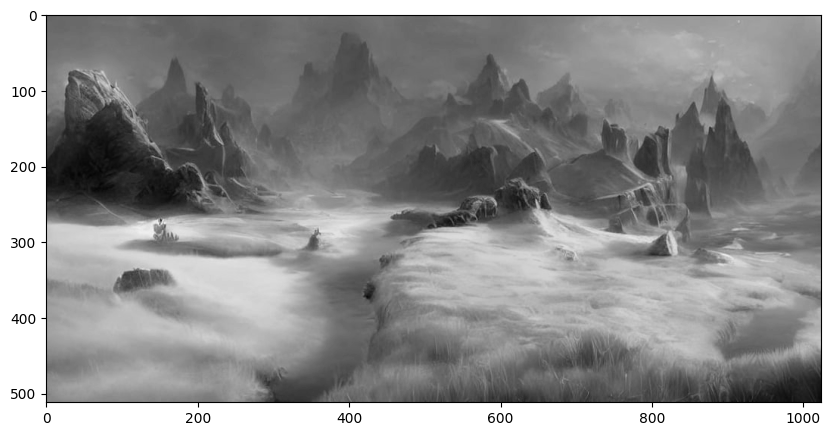

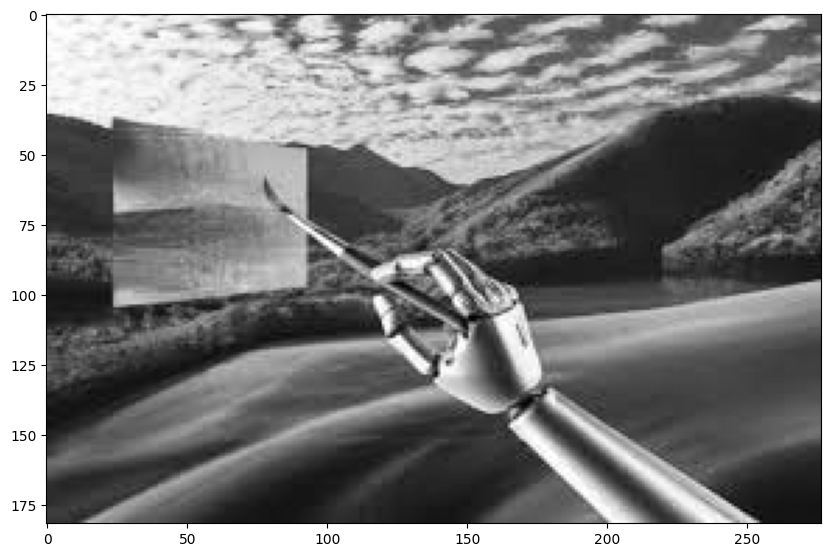

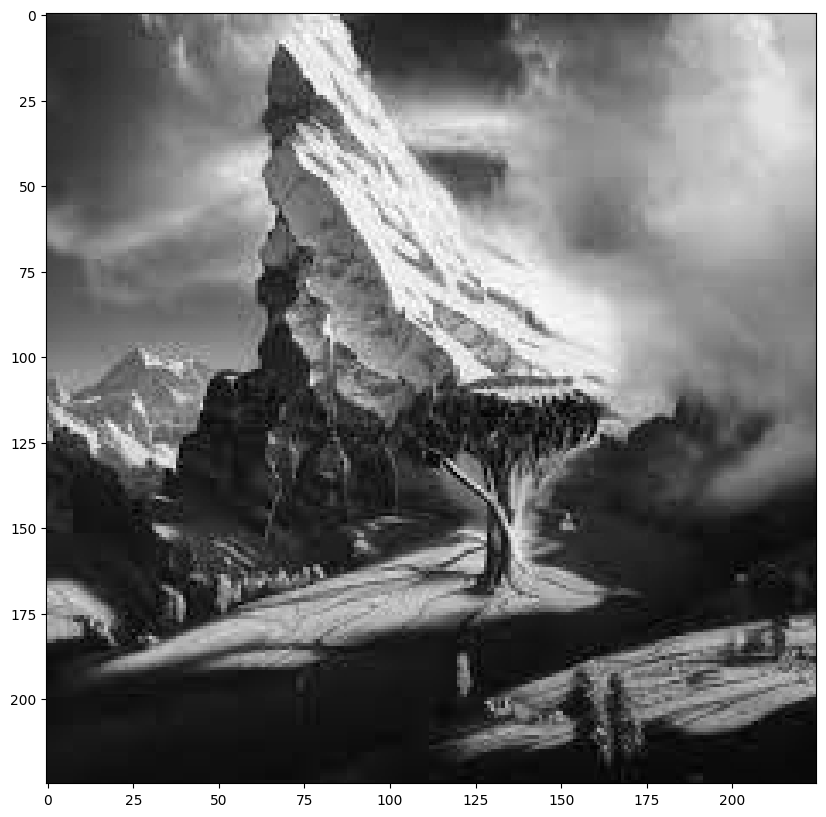

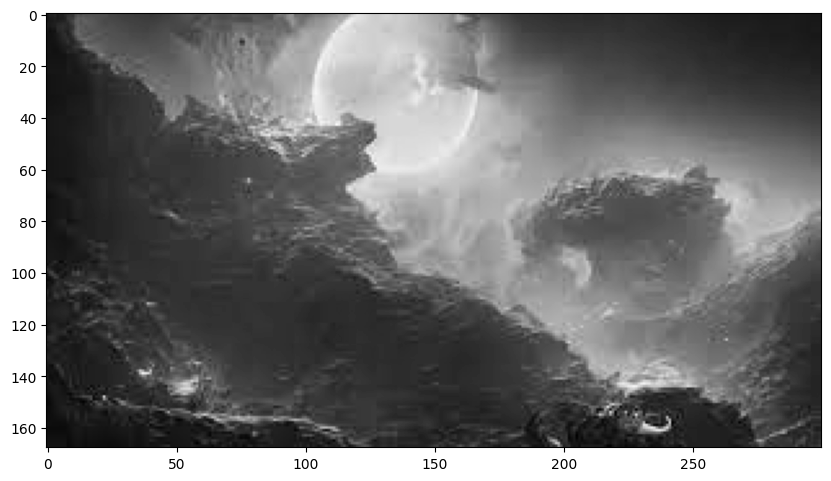

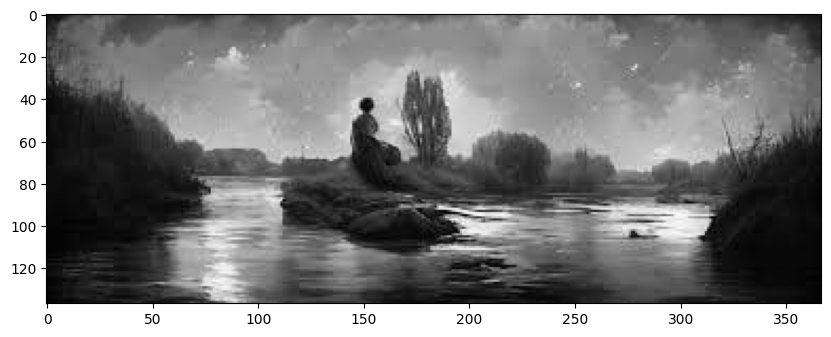

In [39]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage # image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

for i in range(6):
    name = 'asset/' + str(i) + '.jpg'
    img = plt.imread(name)
    img = rgb2gray(img)
    plt.figure(figsize = (10, 10)) # this allows you to control the size of the displayed image
    plt.imshow(img)

## Step 1:
a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

In [6]:
def compute_gradient(img, sigma, threshold = 0):
    '''
    Inputs: input image, sigma and threshold parameter
    Outputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    '''
    intensity_x = ndimage.gaussian_filter(img, sigma, order = [0, 1])
    intensity_y = ndimage.gaussian_filter(img, sigma, order = [1, 0])
    g_norm = np.sqrt(intensity_x ** 2 + intensity_y ** 2)
    g_theta = np.arctan2(intensity_y, intensity_x)
    if threshold > 0:
        g_norm[g_norm < threshold] = 0
        g_norm[g_norm >= threshold] = 1
    return g_norm, g_theta


The sigma parameter is the standard deviation of the Gaussian kernel, it determines the amount of smoothing applied to the image before computing the gradient. Larger values of sigma result in more smoothing and a wider spread of the gradient, while smaller values result in less smoothing and a more localized gradient. The order parameter determines the order of the derivative to be computed. An order of 0 means the convolution is with a Gaussian kernel. First-order derivatives (i.e., order = 1) capture the edges in the image, while higher-order derivatives capture finer details.

To reduce the number of false edges in the gradient magnitude, a threshold is applied. All values below the threshold are set to zero. If the threshold was too low, there would be false positive edges. If the threshold was too high, there would be false negative edges. The threshold parameter controls the sensitivity of the binary image to the gradient magnitude. Higher values of the threshold result in a more strict thresholding of the gradient, while lower values result in a more lenient thresholding.

## Step 2:
b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary images with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [7]:
def non_max_suppression(g_norm, g_theta):
    '''
    Inputs: g_norm - thresholded norm of the gradient, g_theta - gradient orientation
    Outputs: I - image processed with non-max supression
    '''
    row, col = g_norm.shape
    Z = np.zeros((row, col), dtype = np.int32)
    angle = g_theta * 180. / np.pi
    angle[angle < 0] += 180
    for i in range(1, row - 1):
        for j in range(1, col - 1):
            a, b = 255, 255
            if(0 <= 22.5) or (157.5 <= angle[i, j] <= 180): # angle 0
                a, b = g_norm[i, j + 1], g_norm[i, j - 1]
            elif(22.5 <= angle[i, j] < 67.5): # angle 45
                a, b = g_norm[i + 1, j - 1], g_norm[i - 1, j + 1]
            elif(67.5 <= angle[i, j] < 112.5): # angle 90
                a, b = g_norm[i + 1, j], g_norm[i - 1, j]
            elif(112.5 <= angle[i, j] < 157.5): # angle 135
                a, b = g_norm[i - 1, j - 1], g_norm[i + 1, j + 1]
            if(g_norm[i, j] >= a) and (g_norm[i, j] >= b):
                Z[i, j] = g_norm[i, j]
            else:
                Z[i, j] = 0
    return Z


## Step 3:
c- Combine 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

In [51]:
def threshold(img, highThreshold, lowThreshold):
    '''
    Inputs: img - image processes with non-max supression, 
            highThreshold,lowThreshold - high and low threshodl ratios
    Outputs: res - output image, weak, strong - pixel values assiged to weak and strong images
    '''
    highThreshold *= img.max()
    lowThreshold *= highThreshold
    row, col = img.shape
    res = np.zeros((row, col), dtype = np.int32)
    weak = np.int32(25)
    strong = np.int32(255)
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    return (res, weak, strong)


## Step 4:
d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step c with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighbors are weak pixels. If they are, add them to the list of pixels to visit.

In [9]:
def hysteresis(img, weak, strong):
    '''
    Inputs: res - thresholded NMS image, 
    weak, strong - pixel values assiged to weak and strong images
    
    Outputs: img - result after hysteresis
    '''
    row, col = img.shape  
    for i in range(1, row - 1):
        for j in range(1, col - 1):
            if(img[i, j] == weak):
                if((img[i + 1, j - 1] == strong) or (img[i + 1, j] == strong) or (img[i + 1, j + 1] == strong)
                    or (img[i, j - 1] == strong) or (img[i, j + 1] == strong)
                    or (img[i - 1, j - 1] == strong) or (img[i - 1, j] == strong) or (img[i - 1, j + 1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img


## Step 5:
e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.

## effects of choosing different parameters

The gaussian filter is $g: \mathbb{R} ^ 2 \rightarrow \mathbb{R}, g(x, y) = \frac{1}{2\pi\sigma ^ 2} e ^ {-(x ^ 2 + y ^ 2) / (2\sigma ^ 2)}$

$\sigma$ is the standard deviation of the gaussian distribution.

The sigma parameter of the gaussian filter is the standard deviation. As sigma increases, the gaussian kernel becomes wider and smoother, more pixels around each pixel in the image will be included in the smoothing operation, the convolved image becomes more blurry. When sigma decreases, the convolved image is less blurry and the edges are more accentuated and distinct, but then the convolved image would be subject to the effects of noise.

As the threshold increases, the number of edges included in the image decreases, there are fewer false edges, but then it may have more gaps in the contours since there are too many false negatives.

As the threshold decreases, the number of edges included in the image increases, there are more false edges and more false positives.

The double threshold algorithm is designed so that the pixels with the intensity above or equal to the highThreshold are first included in the image and pixels with the intensity below the lowThreshold are excluded from the image. Then the algorithm checks these pixels with the intensity that are less then the highThreshold but greater than or equal to the lowThreshold to see whether these pixels are adjacent to the strong pixels, if so, these pixels would be included in the final image.

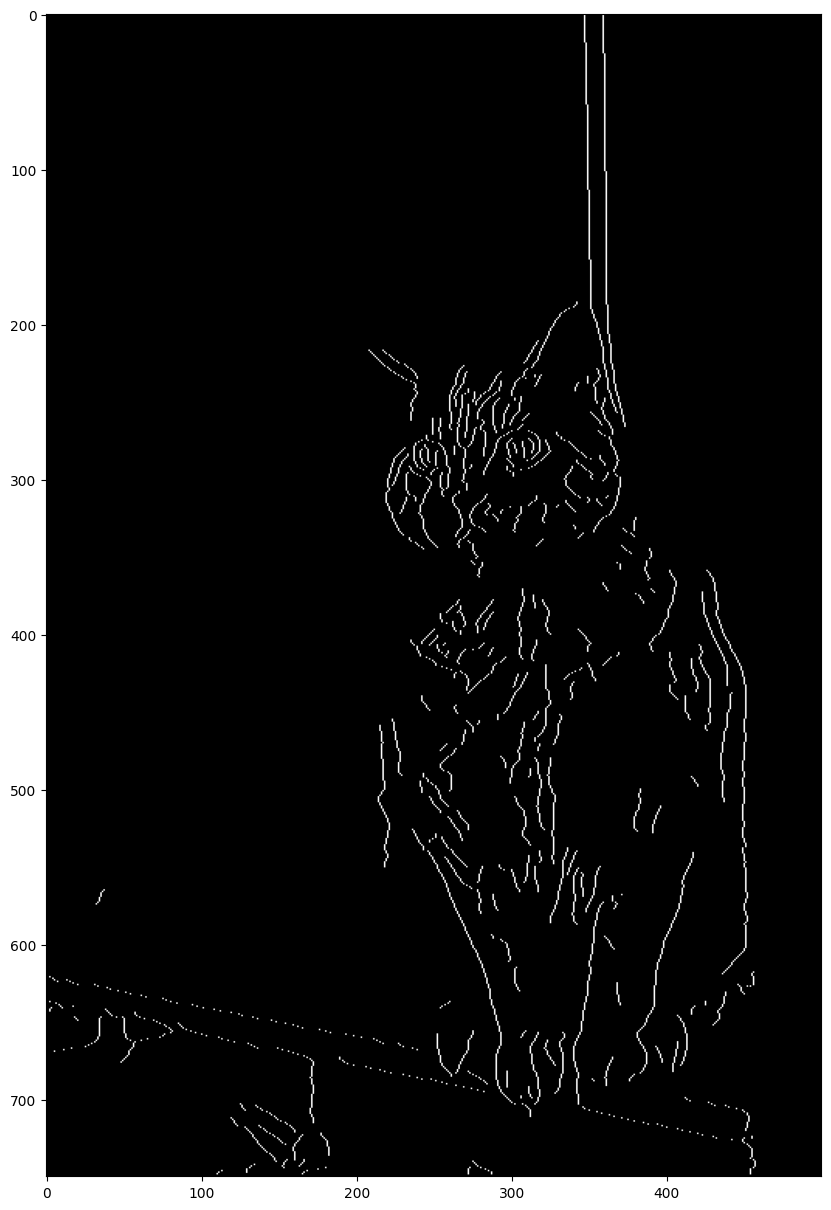

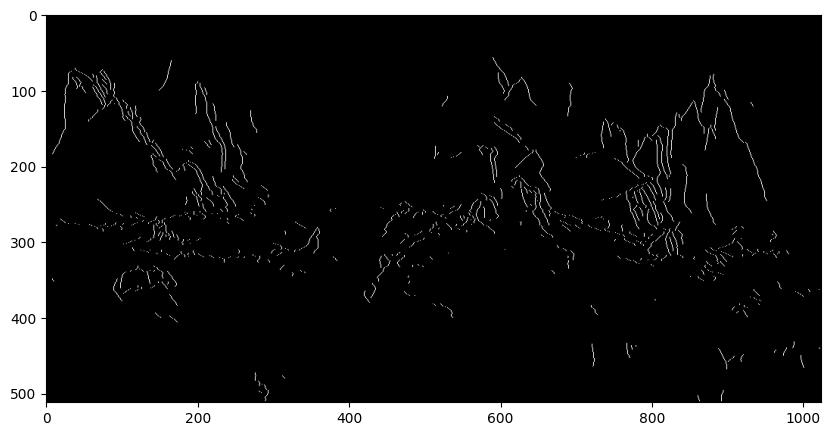

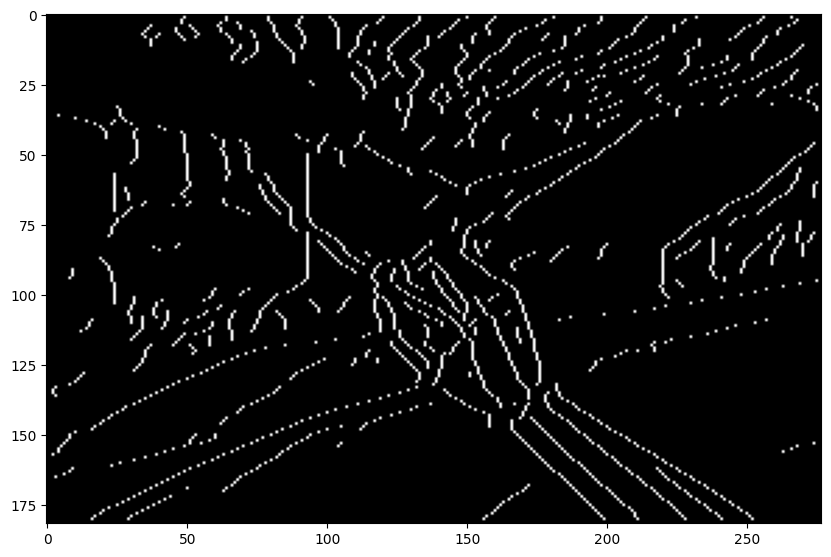

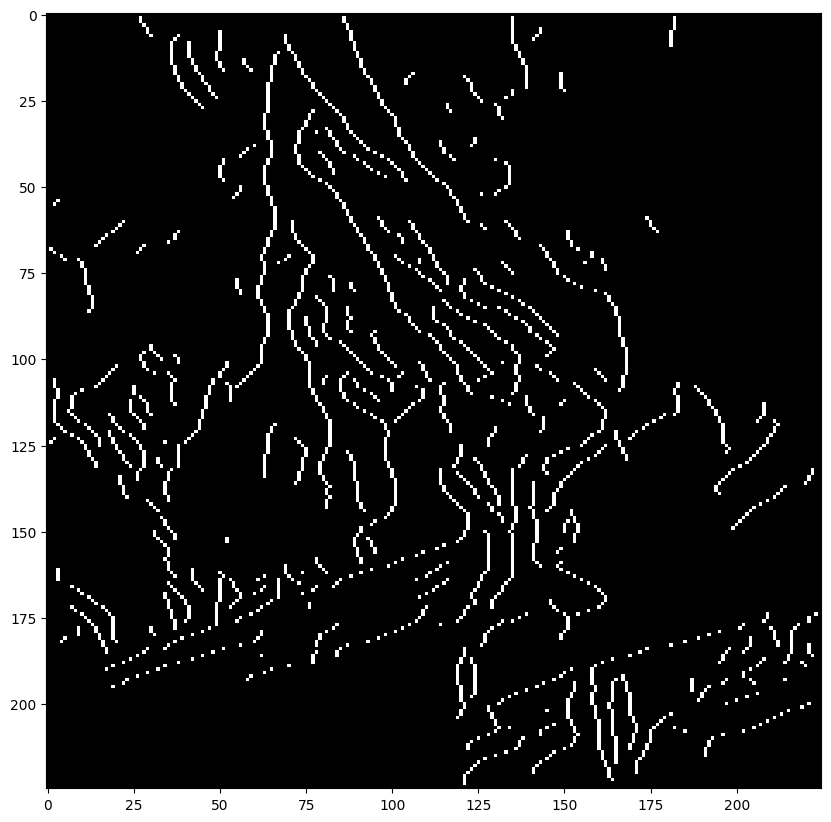

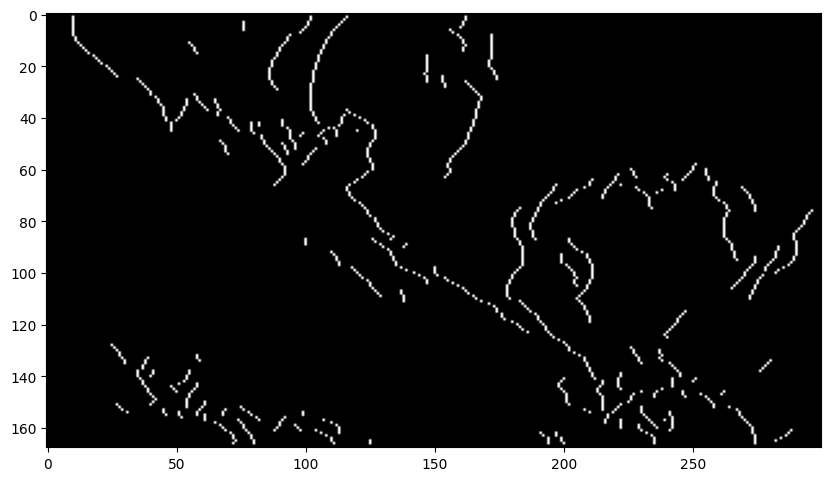

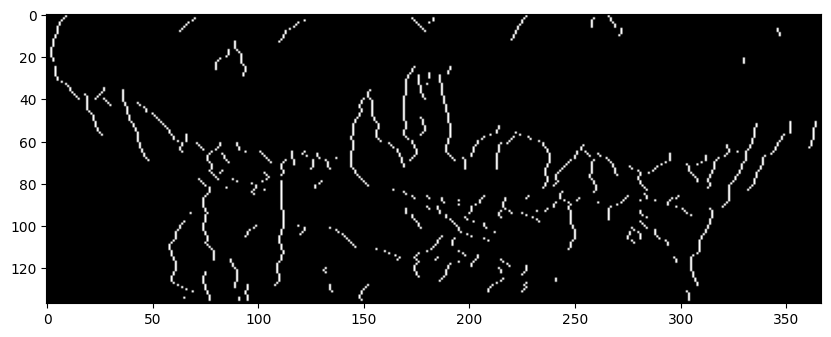

In [88]:
# parameters to check
sigma = 2
lowThreshold = 0.09
highThreshold = 0.2
weak_pixel = 100
strong_pixel = 255

for i in range(6):
    name = 'asset/' + str(i) + '.jpg'
    img = plt.imread(name)
    img = rgb2gray(img)
    gradientMat, thetaMat = compute_gradient(img, sigma)
    # plt.figure(figsize = (10, 20))
    # plt.imshow(ndimage.gaussian_filter(img, sigma))
    nonMaxImg = non_max_suppression(gradientMat, thetaMat)
    thresholdImg, weak, strong = threshold(nonMaxImg, highThreshold, lowThreshold)
    img_final = hysteresis(thresholdImg, weak, strong)
    plt.figure(figsize = (10, 20))
    plt.imshow(img_final)